In [21]:
# Code Credits = https://www.tensorflow.org/tutorials/images/transfer_learning
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.keras import Sequential

# Data Preparation Happens here

In [2]:
# # Downloading the images
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# # destination_folder = '/home/vishnu/practice_codes/video_analysis_practice/video-analytics-e2e/TransferLearning_CatsAndDogs/images/'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin = _URL, extract = True)

In [3]:
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
# train_dir = os.path.join(PATH, 'train')
# validation_dir = os.path.join(PATH, 'validation')

# BATCH_SIZE = 32
# IMG_SIZE = (160, 160)

In [87]:
# # getting the training and validation dataset 
# # image_dataset_from_directory generates the tf.data.Dataset for training and validation
# # There has to be a pre defined format of directory
# train_dataset = image_dataset_from_directory(train_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)
# validation_dataset = image_dataset_from_directory(validation_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

In [23]:
# Directories for training and validation set
train_dir = '/home/vishnu/practice_codes/video_analysis_practice/video-analytics-e2e/TransferLearning_CatsAndDogs/images/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
validation_dir = '/home/vishnu/practice_codes/video_analysis_practice/video-analytics-e2e/TransferLearning_CatsAndDogs/images/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [54]:
train_dataset = image_dataset_from_directory(directory = train_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)
validation_dataset = image_dataset_from_directory(directory = validation_dir, shuffle = True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [55]:
train_dataset
validation_dataset

<BatchDataset shapes: ((None, 240, 240, 3), (None,)), types: (tf.float32, tf.int32)>

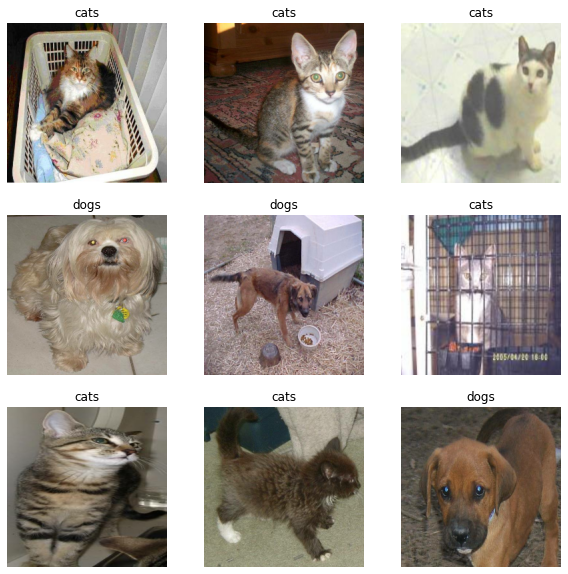

In [56]:
# plotting first few images
class_names = train_dataset.class_names

plt.figure(figsize = (10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        image = images[i]
        label = labels[i]
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(class_names[label])
        plt.axis('off')

In [47]:
val_batch = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batch // 5)
validation_dataset = validation_dataset.skip(val_batch // 5)
print(test_dataset)

<TakeDataset shapes: ((None, 240, 240, 3), (None,)), types: (tf.float32, tf.int32)>


In [48]:
print('%d' % (cardinality(validation_dataset)))
print('%d' % cardinality(test_dataset))

26
6


In [57]:
# # improving the performance 
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [58]:
# data augmentation
# this is for wrangling the image and generating more images for training
data_augmentation = Sequential(
    layers = [tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2)]
)

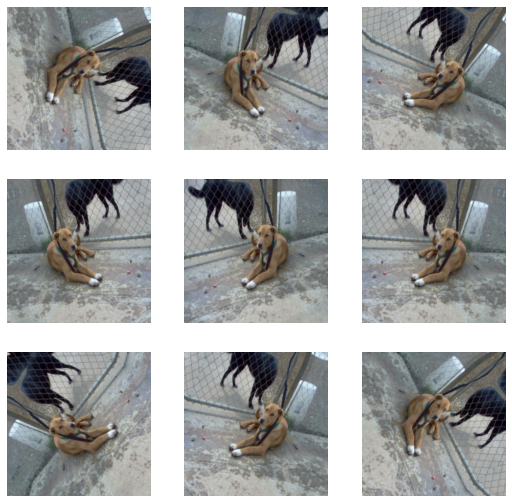

In [86]:
# taking only 1 image and see the augmentation
train_dataset.class_names

for images, labels in train_dataset.take(1):
    plt.figure(figsize = (9, 9))
    first_image = images[0]
    label = labels[0]
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.axis('off')
        # first_image = data_augmentation(first_image)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)

# Transfer Learning Happens here

In [88]:
# preprocessing the input 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [89]:
# Downloading pre trained Mobile net V2 from tensorflow
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [97]:
# converting the images into sizes expected by MobileNetV2
image_batch, labels_batch = next(iter(train_dataset))

features_batch = base_model(image_batch)

In [101]:
# freezing the model not to train anymore
base_model.trainable = False

In [107]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(features_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [110]:
# dense layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [116]:
# Adding few layers on top of pre defined layer
inputs = tf.keras.Input(shape = (240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [119]:
# compiling the model
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= base_learning_rate),\
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),\
        metrics = ['accuracy'])

In [121]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (240, 240, 3)             0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 240, 240, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 240, 240, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [123]:
# Initial evaluation the model
initial_epochs = 10
loss, accuracy = model.evaluate(validation_dataset)
print(loss, accuracy)

32/32 [==============================] - 8s 244ms/step - loss: 0.6633 - accuracy: 0.5720
0.6633180379867554 0.5720000267028809


In [124]:
# Training the model
history = model.fit(train_dataset, epochs = initial_epochs, validation_data = validation_dataset)

Epoch 1/10
63/63 [==============================] - 27s 408ms/step - loss: 0.3148 - accuracy: 0.8475 - val_loss: 0.1118 - val_accuracy: 0.9730
Epoch 2/10
63/63 [==============================] - 26s 420ms/step - loss: 0.1416 - accuracy: 0.9470 - val_loss: 0.0726 - val_accuracy: 0.9810
Epoch 3/10
63/63 [==============================] - 26s 407ms/step - loss: 0.1164 - accuracy: 0.9555 - val_loss: 0.0594 - val_accuracy: 0.9840
Epoch 4/10
63/63 [==============================] - 25s 401ms/step - loss: 0.1019 - accuracy: 0.9620 - val_loss: 0.0513 - val_accuracy: 0.9850
Epoch 5/10
63/63 [==============================] - 25s 393ms/step - loss: 0.1001 - accuracy: 0.9615 - val_loss: 0.0464 - val_accuracy: 0.9850
Epoch 6/10
63/63 [==============================] - 24s 378ms/step - loss: 0.0905 - accuracy: 0.9650 - val_loss: 0.0438 - val_accuracy: 0.9870
Epoch 7/10
63/63 [==============================] - 24s 383ms/step - loss: 0.0806 - accuracy: 0.9640 - val_loss: 0.0403 - val_accuracy: 0.9890